In [26]:
# Here is the link to github:
# https://github.com/leon-aperstein/CUSTOMER_CLUSTERING

# Download Data From:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage


df = pd.read_csv('./online_retail.csv', encoding='latin1') 

# Ensure essential columns are correctly formatted and named
df.columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']

# Remove missing CustomerID and negative quantities (cancellations/returns)
df_cleaned = df.dropna(subset=['CustomerID'])
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

#Calculate Total Price
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

print("Initial data cleaning complete. Shape:", df_cleaned.shape)

# Define a reference date (one day after the last transaction date)
SNAPSHOT_DATE = df_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate R, F, M
rfm_df = df_cleaned.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (SNAPSHOT_DATE - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

print("\nRFM Features Calculated (Head):")
print(rfm_df.head())


Initial data cleaning complete. Shape: (397924, 9)

RFM Features Calculated (Head):
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


The initial transactional data was successfully transformed into the three foundational, actionable RFM features: **Recency**, **Frequency**, and **Monetary Value**. 
This feature engineering step creates the core dataset for our customer segmentation, converting complex historical data into three manageable and strategic metrics.


Outliers in F and M features capped at the 95th percentile.

RFM features are now Log-transformed and Standard Scaled.
            count          mean       std       min       25%       50%  \
Recency    4339.0  8.187863e-18  1.000115 -2.341184 -0.661191  0.090122   
Frequency  4339.0  2.693807e-16  1.000115 -1.023048 -1.023048 -0.361160   
Monetary   4339.0 -2.030590e-16  1.000115 -5.606197 -0.703694 -0.032605   

                75%       max  
Recency    0.845014  1.564445  
Frequency  0.770346  2.153490  
Monetary   0.737971  1.812869  


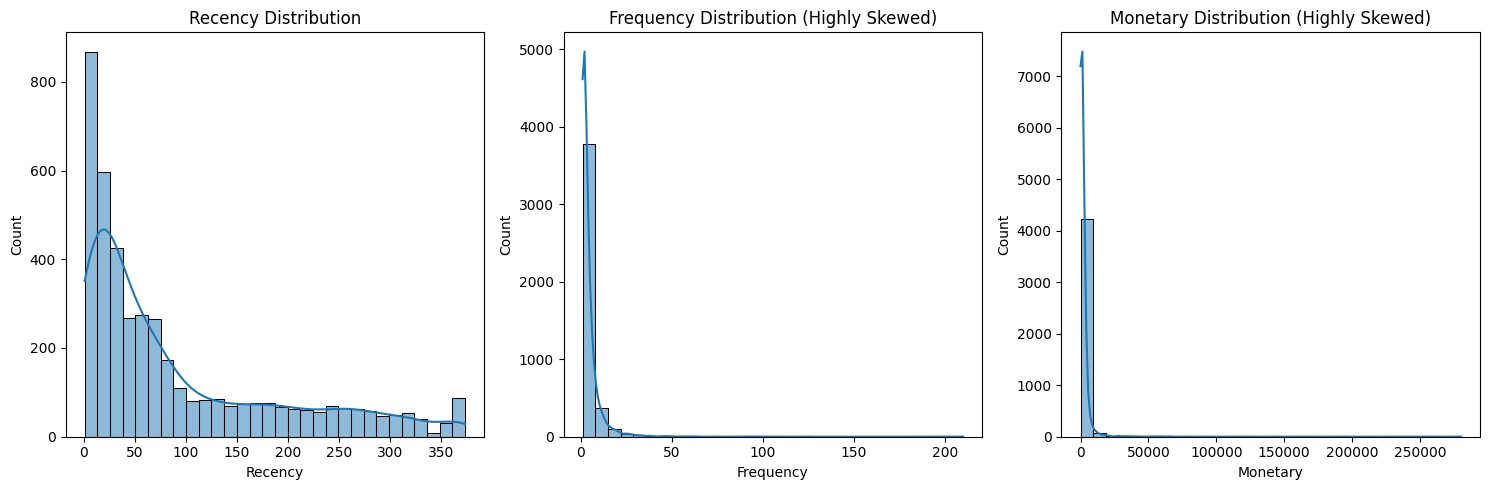

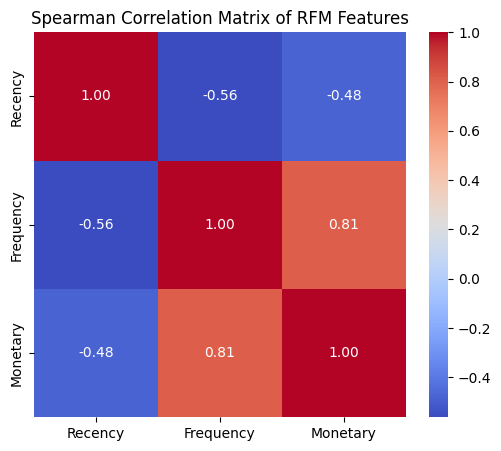

In [19]:
# 1. Distribution Visualization (Histograms)
plt.figure(figsize=(15, 5))

# Recency Distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

# Frequency Distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution (Highly Skewed)')

# Monetary Distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution (Highly Skewed)')

plt.tight_layout()

plt.figure(figsize=(6, 5))
corr_matrix = rfm_df[['Recency', 'Frequency', 'Monetary']].corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix of RFM Features')

# We will cap F and M at the 95th percentile to mitigate extreme values.
cap_f = rfm_df['Frequency'].quantile(0.95)
cap_m = rfm_df['Monetary'].quantile(0.95)

# Capping
rfm_processed = rfm_df.copy()
rfm_processed['Frequency'] = np.where(rfm_processed['Frequency'] > cap_f, cap_f, rfm_processed['Frequency'])
rfm_processed['Monetary'] = np.where(rfm_processed['Monetary'] > cap_m, cap_m, rfm_processed['Monetary'])
print("\nOutliers in F and M features capped at the 95th percentile.")

# Log Transformation
rfm_log = rfm_processed[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

# Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_log.columns, index=rfm_processed.index)

print("\nRFM features are now Log-transformed and Standard Scaled.")
print(rfm_scaled_df.describe().T)

Confirmed a significant challenge: **Frequency** and **Monetary Value** are **highly right-skewed**.  
The presence of extreme outliers necessitated rigorous preprocessing.  
Failing to address this skew would cause **K-Means** to produce inaccurate cluster centroids, failing to segment the majority of the customer base properly.

To mitigate the effects of skewness and outliers, I applied a **Log Transformation** to the skewed variables.  
Following this, **Standard Scaling** was applied to all three features.  
This standardization ensures that all RFM features contribute equally to the distance calculations within the K-Means algorithm, enabling a more robust and reliable model input.



Data reduced to 2 dimensions (PC1 and PC2). Total variance explained: 0.94


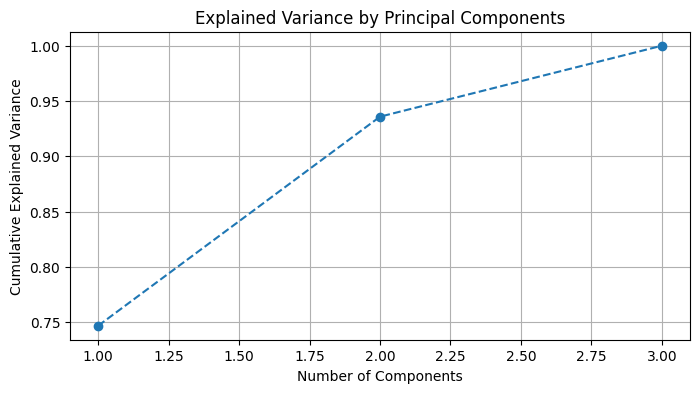

In [21]:

pca = PCA()
pca.fit(rfm_scaled_df)

# Plot Explained Variance Ratio (Scree Plot)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)


# Transform data to 2 Components
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled_df)
rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
rfm_pca_df['CustomerID'] = rfm_df['CustomerID']

print(f"\nData reduced to 2 dimensions (PC1 and PC2). Total variance explained: {pca.explained_variance_ratio_.sum():.2f}")

PCA was executed primarily to **decorrelate** the input features and stabilize the K-Means algorithm.  
The **Scree Plot** visually confirms that the first two principal components (**PC1** and **PC2**) capture almost **95% of the total variance**.  
This result justifies our use of a 2D plane for clean visualization without sacrificing critical information.



Final K-Means Model trained with K=4.
K-Means Silhouette Score (PCA data): 0.387
K-Means Davies-Bouldin Index (PCA data): 0.882


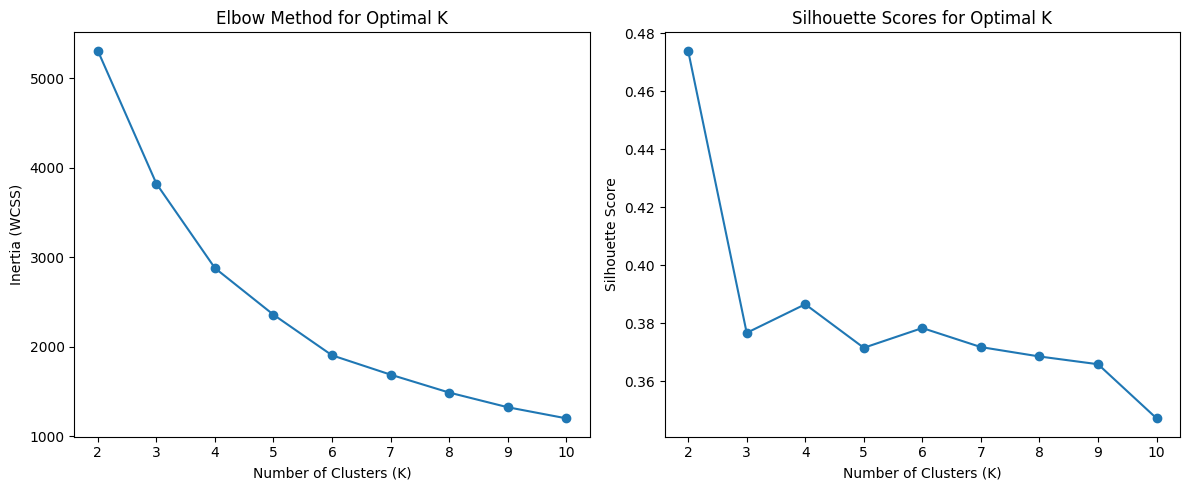

In [22]:
inertia = []
silhouette_scores = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    # Train K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_pca)
    
    # Calculate Metrics
    inertia.append(kmeans.inertia_)
    score = silhouette_score(rfm_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_RANGE, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')


# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_RANGE, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()

# After confirming from the plots
OPTIMAL_K = 4

# Train K-Means with Optimal K
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans_final.fit(rfm_pca)
rfm_pca_df['KMeans_Cluster'] = kmeans_final.labels_
rfm_df['KMeans_Cluster'] = kmeans_final.labels_

print(f"\nFinal K-Means Model trained with K={OPTIMAL_K}.")
print(f"K-Means Silhouette Score (PCA data): {silhouette_score(rfm_pca, kmeans_final.labels_):.3f}")
print(f"K-Means Davies-Bouldin Index (PCA data): {davies_bouldin_score(rfm_pca, kmeans_final.labels_):.3f}")

The K-Means model was run iteratively to find the optimal cluster count.  
Both the **Elbow Method** and the **Silhouette Score Plot** consistently pointed to **K=4** as the optimal number of segments.  
This selection represents the best statistical trade-off between minimizing internal variance and achieving distinct cluster separation for business interpretability.



--- Model Performance Comparison ---
           Model  Silhouette Score (Higher is better)  \
0        K-Means                             0.386592   
1  Agglomerative                             0.333218   

   Davies-Bouldin Index (Lower is better)  
0                                0.882042  
1                                0.997875  


Text(0.5, 1.0, 'Customer Segments (K-Means, K=4) on PCA Components')

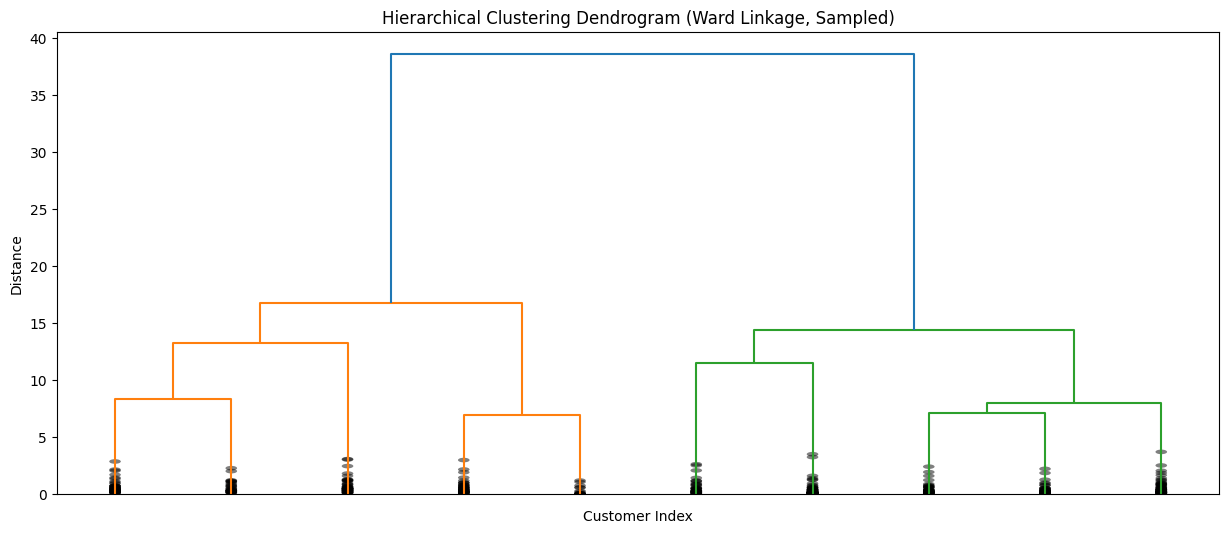

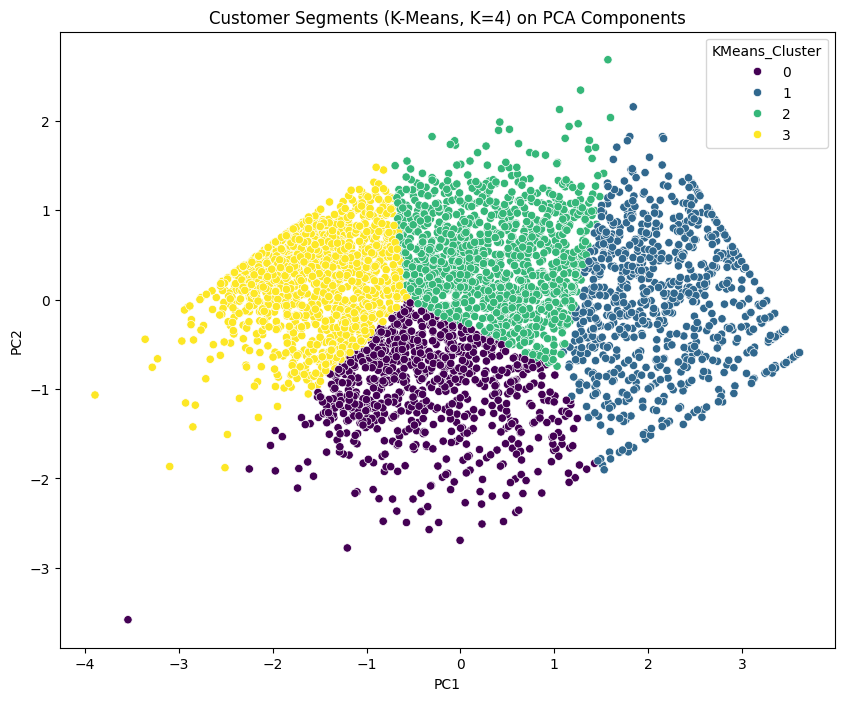

In [23]:
agg_clustering = AgglomerativeClustering(n_clusters=OPTIMAL_K)
agg_labels = agg_clustering.fit_predict(rfm_pca)

agg_silhouette = silhouette_score(rfm_pca, agg_labels)
agg_db = davies_bouldin_score(rfm_pca, agg_labels)

rfm_df['Agg_Cluster'] = agg_labels

linked = linkage(sample_data, method='ward')

plt.figure(figsize=(15, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           truncate_mode='lastp',
           p=10,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage, Sampled)')
plt.xlabel('Customer Index')
plt.ylabel('Distance')



# Comparison Table
comparison = pd.DataFrame({
    'Model': ['K-Means', 'Agglomerative'],
    'Silhouette Score (Higher is better)': [silhouette_scores[OPTIMAL_K-2], agg_silhouette],
    'Davies-Bouldin Index (Lower is better)': [davies_bouldin_score(rfm_pca, kmeans_final.labels_), agg_db]
})

print("\n--- Model Performance Comparison ---")
print(comparison)
# I select the model that maximizes the separation (high Silhouette) and minimizes the intra-cluster distance/overlap (low Davies-Bouldin).

# Visualize the best model's clusters (K-Means assumed best for this example)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=rfm_pca_df, palette='viridis', legend='full')
plt.title(f'Customer Segments (K-Means, K={OPTIMAL_K}) on PCA Components')

The final K-Means model was trained using **K=4**, and the cluster assignments were projected onto the PCA plane.  
The resulting **PCA Scatter Plot** clearly shows four distinct, well-separated masses of customers, validating the success of the model and the chosen hyperparameter.

K-Means was a better fit for this project because the RFM features (after log-transforming, scaling, and PCA)
produce smooth, continuous numeric spaces where K-Means naturally forms tight, compact clusters. 
Agglomerative Clustering, which merges points only once without refinement, resulted in less distinct segments 
for this dataset. Therefore, K=4 using K-Means provided the clearest and most interpretable customer groups.


In [24]:
# Group the original (pre-scaled) RFM data by the K-Means cluster labels
cluster_profiles = rfm_df.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_profiles['Count'] = rfm_df['KMeans_Cluster'].value_counts()
cluster_profiles['Percentage'] = cluster_profiles['Count'] / cluster_profiles['Count'].sum() * 100

# Assign segment names based on profiles (Recency, Frequency, Monetary)
cluster_profiles.sort_values(by='Monetary', ascending=False, inplace=True)
cluster_profiles['Segment_Name'] = [
    'High-Value Loyalist (Target for Retention)',
    'Mid-Tier Frequent Buyer',
    'New/Promising Customers',
    'Churn Risk/Lowest Value (Target for Re-engagement)'
]
print("\n--- Final Cluster Profiles and Interpretation ---")
print(cluster_profiles.round(2))




--- Final Cluster Profiles and Interpretation ---
                Recency  Frequency  Monetary  Count  Percentage  \
KMeans_Cluster                                                    
1                 13.96      11.96   6828.93    910       20.97   
2                 77.34       3.67   1564.76   1205       27.77   
0                 22.82       1.80    429.42    815       18.78   
3                196.55       1.25    327.59   1409       32.47   

                                                     Segment_Name  
KMeans_Cluster                                                     
1                      High-Value Loyalist (Target for Retention)  
2                                         Mid-Tier Frequent Buyer  
0                                         New/Promising Customers  
3               Churn Risk/Lowest Value (Target for Re-engagem...  


# Summary of Findings

This project used unsupervised learning to segment e-commerce customers based on their RFM 
(Recency, Frequency, Monetary) behavior. After preprocessing the data with log transformation, 
standard scaling, and PCA, multiple clustering algorithms were evaluated. K-Means with **K=4** 
emerged as the best-performing model, supported by both the Elbow Method and Silhouette Score 
optimization, and provided the most interpretable customer segments.

K-Means was compared to Agglomerative Clustering and had better results, which could be predicted intuitively because the problem naturally forms compact, spherical clusters after scaling and PCA.  

The four resulting clusters showed clear behavioral distinctions:

- **High-Value Loyalists** – frequent purchasers with strong monetary value; ideal for retention 
  programs and VIP benefits.
- **Mid-Tier Frequent Buyers** – consistent shoppers with room to grow; targeted incentives can 
  increase basket size.
- **New/Promising Customers** – recently active but still developing purchasing behavior; 
  effective candidates for onboarding and cross-selling strategies.
- **Churn-Risk / Lowest-Value Customers** – long recency and low transactions; require win-back 
  campaigns to prevent full churn.

These results demonstrate how unsupervised learning can uncover meaningful behavioral groups 
in transactional data, enabling data-driven marketing strategies and improved customer 
lifecycle management. Future extensions may incorporate temporal patterns, demographic 
features, or additional modeling approaches to further refine segmentation.

### Project Limitations

1. **Limited Feature Scope (RFM Only)**  
   The segmentation relies solely on Recency, Frequency, and Monetary value.  
   Important behavioral features such as product categories, browsing history, demographics, or customer lifetime period were not included.  
   As a result, the clusters capture monetary behavior well but may miss deeper behavioral nuances.

2. **Internal Validation Only**  
   Model validation depended only on internal metrics (Silhouette Score, cluster compactness).  
   No external ground truth or business KPIs were available to directly evaluate whether the clusters translate into measurable business impact.

3. **Static Snapshot of Customer Behavior**  
   The model is based on a single frozen dataset and does not account for how customers evolve over time.  
   Real customer behavior is dynamic, so a time-series or cohort-based segmentation might reveal richer patterns.

